In [1]:
from matplotlib import pylab
import nengo
import numpy as np

%matplotlib inline

In [2]:
STEP = 0.001#s
EQ_MARGIN = 0.0001
SIM_TIME = 50#s
SWITCH_TIME = 0.500#s
SWITCH_TIME2 = 0.050#s
CHECKS = 45
DIVIDER = 1
SIM_TIME2 = SWITCH_TIME2#s
DIST = 10
D_STEP = 10
MOD = 23
B_STEP = 180/CHECKS
def fn(j, vals, vals2, vals3):
    s = SWITCH_TIME
    vs = vals
#    cur = STEP
    i = 0
    #prep yield
    t = yield
    init = t
    cur = init
    #print t
    while True:
    #initial training
        if -EQ_MARGIN <= t-SIM_TIME-init <= EQ_MARGIN:
            break
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            #print '*********************************************'
            cur = t
            i += 1
        t = yield [vs[i], 0, 1]
        #print cur, t, t-cur, s, t-cur-s, -EQ_MARGIN <= t-cur-s <= EQ_MARGIN
        j.append(vs[i])
    s = SWITCH_TIME2
    vs = vals2
    cur = t
    i = 0
    while True:
    #assessment 1
        if i >= len(vals2):
            print 'too far', t
            break
        t = yield [vs[i], 0, 0]
        j.append(vs[i])
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
    s = SWITCH_TIME
    vs = vals3
    cur = t
    resim_time = SIM_TIME/DIVIDER+t
    i = 0
    while True:
    #retraining
        if -EQ_MARGIN <= t-resim_time <= EQ_MARGIN:
            break
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
        t = yield [vs[i], 1, 0.5]
        j.append(vs[i])
    s = SWITCH_TIME2
    vs = vals2
    cur = t
    i = 0
    while True:
    #assessment 2
        if i >= len(vals2):
            print 'too far', t
            break
        t = yield [vs[i], 0, 0]
        j.append(vs[i])
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
    while True:
        t = yield [0, 0, 0]

In [3]:
model = nengo.Network(seed=3)
dist = nengo.dists.Uniform(-1.0, 1.0)
vals = dist.sample((SIM_TIME/SWITCH_TIME)+1)
vals3 = dist.sample((SIM_TIME/SWITCH_TIME/DIVIDER)+1)
vals2 = np.linspace(-1, 1, CHECKS)
GAP = vals2[1]-vals2[0]
j=[]
func = fn(j, vals, vals2, vals3)
func.next()
func = func.send

In [4]:
#xx = [np.sin(x*np.pi/2) for x in np.linspace(-1, 1, 45)]
#yy = [np.cos(x*np.pi/2) for x in np.linspace(-1, 1, 45)]
#print xx
#pylab.plot(xx, yy)
#for i in range(len(xx)-1):
#    pylab.plot([xx[i], 0], [yy[i], 0])

In [5]:
#time = int(2*(SIM_TIME/STEP)+3*(CHECKS*SWITCH_TIME2/STEP))
#print time
#a = [func(0.001*x) for x in range(1, time+1)]

In [6]:
#b = np.array(a)
#c = b[:, 0]
#print list(c).index(-1.0)
#print c[2406700:2406750]
#print c.shape

In [7]:
#d = {}
#z=52200
#for a in set(c[:]):
#    d[a] = 0
#for a in c[:]:
#    d[a] += 1
#for k in d:
#    if d[k] != 500 and d[k] != 1500 and d[k] != 50 and d[k] != 150:
#        print k, d[k]
#print c[0], c[499], c[500], c[999], c[1000], c[1499]
#print c[49998], c[49999]
#print c[3501], c[4001], c[1500], c[2000], c[2001]
#print c[52200-1:52250]
#print [i for i, x in enumerate(c[:z]) if -0.01 < x+0.421665933532 < 0.01]

In [8]:
def convertandmod(v):
    #assumes a left-biased prism
    temp = np.arcsin(v)*2/np.pi
    print temp
    temp -= GAP*MOD/B_STEP
    return np.sin(temp*np.pi/2), np.cos(temp*np.pi/2)

In [9]:
#print np.sin((0.5-(GAP*MOD/B_STEP))*np.pi/2)
#print convertandmod(np.sin(0.5*np.pi/2))

#n=35
#pylab.plot(xx, yy)
#pylab.plot([xx[n], 0], [yy[n], 0])
#pylab.plot([convertandmod(xx[n])[0], 0], [convertandmod(xx[n])[1], 0])

In [10]:
with model:
    stim = nengo.Node(func)
    
    sensory = nengo.Ensemble(n_neurons=400, dimensions=3,
                            intercepts=nengo.dists.Uniform(0.81,0.91))
    
    
    spatial = nengo.Ensemble(n_neurons=400, dimensions=2,
                            intercepts=nengo.dists.Uniform(0.81,0.91))
    
    nengo.Connection(stim, sensory[:],
                     function=lambda x: (np.sin(x[0]*np.pi/2), 
                                         np.cos(x[0]*np.pi/2), 
                                         x[1]))
    
    #nengo.Connection(sensory[:2], sensory[2:], synapse=0.2)
    
    c = nengo.Connection(sensory, spatial, function=lambda x: [0,0],
                         learning_rule_type=nengo.PES(learning_rate=3e-4))
        
    error = nengo.Ensemble(n_neurons=400, dimensions=3)
    
    nengo.Connection(stim[2], error[2])
    nengo.Connection(sensory[:2], error[:2],
                     transform=-1)
    nengo.Connection(error, c.learning_rule, 
                     #0.19 is 17deg shift (need more negative to mitigate it)
                     function=lambda x: x[:2] if x[2] > 0.7 else convertandmod(x[0]) if x[2] > 0.3 else [0, 0])
    #nengo.Connection(spatial, c.learning_rule, synapse=0.1)
    
    nengo.Connection(spatial, error[:2])
    #correct = nengo.Node([0,0])
    #nengo.Connection(correct, error, transform=-1)
    
    spatial_probe = nengo.Probe(spatial.neurons)
    


In [11]:
def sim_gen(time, cnt):
    cur = 0
    yield np.mean(sim.data[spatial_probe][-int(SWITCH_TIME2/STEP):], axis=0) #prep
    while cur <= cnt:
        sim.run(time, progress_bar=False)
        yield np.mean(sim.data[spatial_probe][-int(SWITCH_TIME2/STEP):], axis=0)
        #print sim.data[spatial_probe].shape
        cur += 1
        
def calc_norm(rates, rate_peaks=None):
    #assume that cells with similar peak centers would fall under the same
    #multicellular recording therefore peaks are done relative to all values with similar peaks
    nrm_rates = []
    if rate_peaks is None:
        rate_peaks = np.max(rates, axis=1)
        rate_peaks = np.array([p if p > 0 else 1 for p in rate_peaks])
    max_i = np.argmax(rates, axis=0)
    for j, i in enumerate(max_i):
        nrm_rates.append(rates[:, j]/rate_peaks[i])
    nrm_rates = np.array(nrm_rates).transpose()
    return nrm_rates, rate_peaks

#def align_cut(nrm, dist, num_checks, maxes=None):
    #below uses the protocol from the paper where the center value of the values with >= 50% of
    #the max value is used as the max
    #cut assumes that it is not multimodal
#    if maxes is None:
#        cut = [[(i, neuron_val) for i, neuron_val in enumerate(nrm[:, col]) 
#                if neuron_val >= 0.5] for col in range(nrm.shape[1])]
#        maxes = [(i, neuron_vals[len(neuron_vals)/2][0]) 
#                 for i, neuron_vals in enumerate(cut) 
#                 if len(neuron_vals) > 0]
#    max_cuts = [nrm[mx-dist:mx+dist+1, i] 
#                for i, mx in maxes 
#                if mx >= dist and mx <= num_checks-(dist+1)]
#    return np.array(max_cuts), maxes

def align_cut2(nrm, dist, num_checks, maxes=None):
    if maxes is None:
        #temp = {k: nrm[:, k] for k in range(nrm.shape[1])}
        #print temp[1]
        cut = {col: [(i, neuron_val) for i, neuron_val in enumerate(nrm[:, col]) 
                   if neuron_val > 0.5] 
               for col in range(nrm.shape[1])}
        #print cut[1]
        maxes = {k: neuron_vals[len(neuron_vals)/2][0] for k, neuron_vals in cut.items()
                if len(neuron_vals) > 0}
        for k in cut:
            try:
                maxes[k]
            except KeyError:
                maxes[k] = 0
    max_cuts = {i: nrm[mx-dist:mx+dist+1, i] 
                for i, mx in maxes.items() 
                if mx >= dist and mx <= num_checks-(dist+1)}
    return max_cuts, maxes

def prep_graph(time, cnt, dist):
    sim_g = sim_gen(time, cnt)
    sim_g.next()
    return align_cut(calc_norm(np.array([mean for mean in sim_g])), dist)

def graph_neurons(vals, step):
    for v in range(vals.shape[0]):
        pylab.plot(range(-DIST*step, DIST*step+1, step), vals[v, :])

def graph_mean(mean, step):
    pylab.plot(range(-DIST*step, DIST*step+1, step), mean)
    
def filtered_mean(vals):
    return np.mean([x for x in vals if sum(x) > 0], axis=0)

In [12]:
#a, m = align_cut2(n2, DIST, len(vals2))
#print m.keys() == range(400)

In [13]:
sim = nengo.Simulator(model)

-0.310930235062
0.60033395777
-0.353033171187
-0.131770820653
-0.147964666609
-0.0121276974376
0.457063009476
0.326799903905
0.0566987724852
-0.31214560937
0.0761539885266
0.344518038324
0.570609010105
-0.205023087897
0.136896875686
-0.504203430839
0.0408419330257
0.0736048979464
-0.466359807598
-0.497273142277
-0.0756997111488
0.428440340309
0.238654452009
-0.380078015652
0.545063004552
0.601181788025
-0.346806737001
0.486295514504
-0.439104282232
0.0354486517844
0.0813750469879
0.368566283679
-0.351187851492
0.315611995003
0.25233541304
-0.487845911397
-0.156090378739
0.0580187082794
-0.174168109813
-0.427789047422
-0.183313944301
0.428829340866
-0.2799991562
-0.297452332711
0.11867028909
-0.411309173991
0.0742616218192
0.222891740015
-0.00649639327252
-0.303547048663
-0.43454059342
0.362662901733
-0.457180531563
0.160645579012
0.560264170913
0.0224268351274
0.116426500424
0.0984542956442
0.122810420618
-0.380943540509
0.312295037756
-0.125748989425
0.266687431248
-0.0203154608768
-0

In [14]:
sim.run(SIM_TIME)

Simulation finished in 0:00:20.                                                 


In [15]:
sim_g = sim_gen(SIM_TIME2, len(vals2)-1)
a=sim_g.next()
#print a.shape
mean = np.array([mean for mean in sim_g])
#print mean.shape
#Y = len(j)
#print Y

too far 52.25


In [16]:
n, rate_peaks = calc_norm(mean)

In [17]:
out_, maxes = align_cut2(n, DIST, len(vals2))
out = np.array(out_.values())
print out.shape
print [len(x) for x in out]
mean_out = np.mean(out, axis=0)
print mean_out.shape

(104, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
(21,)


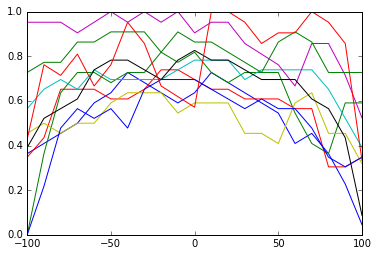

In [18]:
graph_neurons(out[:10], D_STEP)

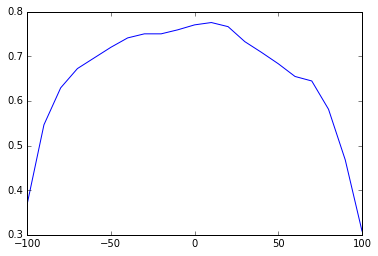

In [19]:
graph_mean(mean_out, D_STEP)

In [20]:
sim.run(SIM_TIME/DIVIDER)

Simulation finished in 0:00:20.                                                 


In [21]:
sim_g = sim_gen(SIM_TIME2, len(vals2)-1)
a2=sim_g.next()
#print a.shape
mean2 = np.array([mean for mean in sim_g])
print mean2.shape

too far 104.5
(45, 400)


In [22]:
n2, rate_peaks2 = calc_norm(mean2)

In [23]:
#Centered the graphs relative to themselves
out_2, maxes2 = align_cut2(n2, DIST, len(vals2))
out2 = np.array(out_2.values())
print out2.shape
print out[0]
print [len(x) for x in out2]
mean_out2 = filtered_mean(out2)
print mean_out2.shape

(94, 21)
[ 0.36363636  0.40909091  0.45454545  0.5         0.59090909  0.63636364
  0.72727273  0.68181818  0.63636364  0.59090909  0.63636364  0.72727273
  0.68181818  0.63636364  0.59090909  0.54545455  0.40909091  0.45454545
  0.36363636  0.22727273  0.04545455]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
(21,)


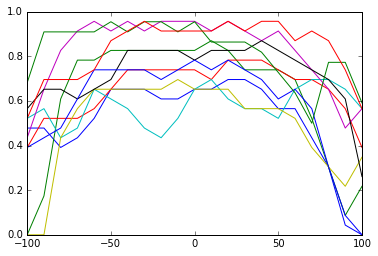

In [24]:
graph_neurons(out2[:10], D_STEP)

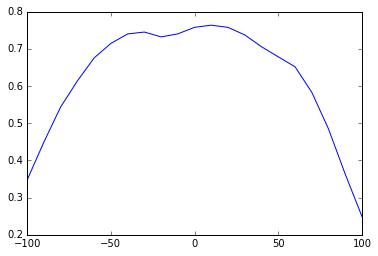

In [25]:
graph_mean(mean_out2, D_STEP)

In [26]:
#Centered the graphs relative to the original distribution
out_3, maxes3 = align_cut2(n2, DIST, len(vals2), maxes)
out3 = np.array(out_3.values())
print out3.shape
print [len(x) for x in out3]
mean_out3 = filtered_mean(out3)
#print np.mean([x for x in out3 if sum(x) > 0], axis=1)
#print np.sum([x for x in out3 if sum(x) > 0], axis=1)
#print mean_out3.shape

(104, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]


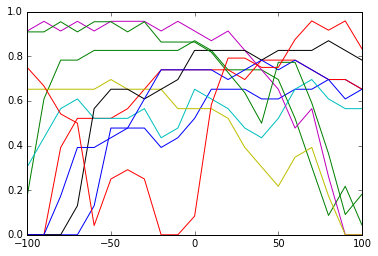

In [27]:
graph_neurons(out3[:10], D_STEP)

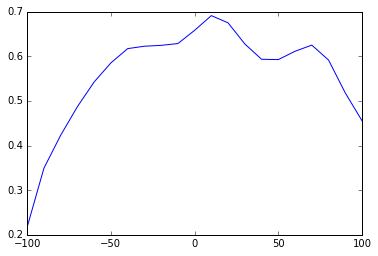

In [28]:
graph_mean(mean_out3, D_STEP)

In [29]:
print out_.keys()[0]
print maxes[1]
print maxes2[1]
print n2[15:18, 1]
print n2[16-DIST:16+DIST+1, 1]
print out_2[1]
print out_3[1]

ttt = []
for k in out_3:
    t = maxes[k]
    ttt.append(out_3[k] == n2[t-DIST:t+DIST+1, k])
print ttt

1
16
22
[ 0.43478261  0.52173913  0.65217391]
[ 0.          0.          0.          0.          0.13043478  0.47826087
  0.47826087  0.47826087  0.39130435  0.43478261  0.52173913  0.65217391
  0.65217391  0.65217391  0.60869565  0.60869565  0.65217391  0.65217391
  0.69565217  0.69565217  0.65217391]
[ 0.47826087  0.47826087  0.39130435  0.43478261  0.52173913  0.65217391
  0.65217391  0.65217391  0.60869565  0.60869565  0.65217391  0.65217391
  0.69565217  0.69565217  0.65217391  0.56521739  0.56521739  0.43478261
  0.30434783  0.04347826  0.        ]
[ 0.          0.          0.          0.          0.13043478  0.47826087
  0.47826087  0.47826087  0.39130435  0.43478261  0.52173913  0.65217391
  0.65217391  0.65217391  0.60869565  0.60869565  0.65217391  0.65217391
  0.69565217  0.69565217  0.65217391]
[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool), 